In [115]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import control as ctl

In [116]:
# Carregar os dados do arquivo MAT
arquivo_mat = r'../dataset/Dataset_Grupo6.mat'
dados_mat = scipy.io.loadmat(arquivo_mat)

In [117]:
# Extrair os dados
tempo = dados_mat['TARGET_DATA____ProjetoC213_Degrau'][0, :]       # Primeira linha como tempo
degrau = dados_mat['TARGET_DATA____ProjetoC213_Degrau'][1, :]  # Segunda linha como valores do degrau
saida_motor = dados_mat['TARGET_DATA____ProjetoC213_PotenciaMotor'][1, :]  # Segunda linha como valores da saída do motor

In [118]:
# Determinar o valor final da resposta e amplitude do degrau
amplitude_degrau = degrau[-1]
valor_final = saida_motor[-1]

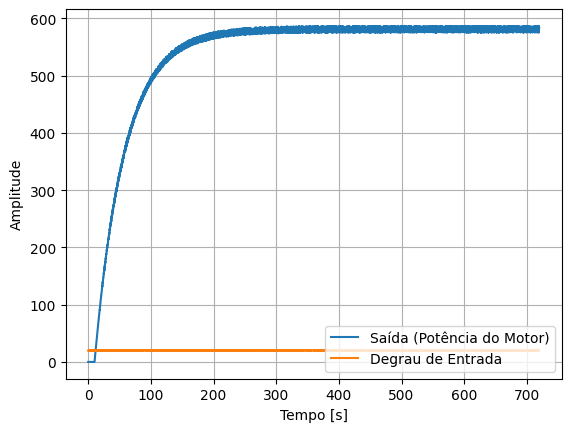

In [119]:
# Plotar o gráfico de entrada e saída
plt.plot(tempo, saida_motor, label='Saída (Potência do Motor)')
plt.plot(tempo, degrau, label='Degrau de Entrada')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.legend(loc="lower right")
plt.grid()
plt.savefig('images/entrada_saida.png')
plt.show()

In [120]:
# Calcular o ganho estático
ganho_estatico = valor_final / amplitude_degrau

In [121]:
# Estimar o theta e a constante de tempo
theta = 0
tau = 0
for i in range(len(saida_motor)):
    if (saida_motor[i] != 0) and (theta == 0):
        theta = tempo[i-1]

    if saida_motor[i] >= (0.6321 * valor_final):
        tau = tempo[i] - theta
        break

print(f'theta (Theta): {theta:.2f}.')
print(f'Constante de Tempo (Tau) = {tau:.2f}s.\n')

theta (Theta): 10.10.
Constante de Tempo (Tau) = 47.50s.



In [122]:
# Estimar K, Tau, e Theta
saida_ajustada = saida_motor - saida_motor[0]
valor_final = saida_motor[-1]
K = valor_final / amplitude_degrau
tempo_t1 = 0
tempo_t2 = 0
for i in range(len(saida_motor)):
    if saida_motor[i] >= 0.283 * valor_final and tempo_t1 == 0:
        tempo_t1 = tempo[i]
    if saida_motor[i] >= 0.6321 * valor_final:
        tempo_t2 = tempo[i]
        break

tau_estimado = 1.5 * (tempo_t2 - tempo_t1)
theta_estimado = tempo_t2 - tau_estimado

print(f"K = {K}, Tau = {tau_estimado}, Theta = {theta_estimado}.")

K = 29.056012945704634, Tau = 47.25, Theta = 10.350000000000001.


In [123]:
# Modelagem do sistema
sistema = ctl.tf(K, [tau_estimado, 1])
pade_aprox = ctl.pade(theta_estimado, 20)
sistema_com_theta = ctl.series(sistema, ctl.tf(*pade_aprox))
tempo_simulado, saida_simulada = ctl.step_response(sistema_com_theta * amplitude_degrau, tempo)

In [124]:
# Calcular o Erro Quadrático Médio (EQM)
erro_quadratico_medio = np.sqrt(np.mean((saida_simulada - saida_motor) ** 2))
print(f'O Erro Quadrático Médio (EQM) é: {erro_quadratico_medio:.4f}.\n')

O Erro Quadrático Médio (EQM) é: 3.7955.



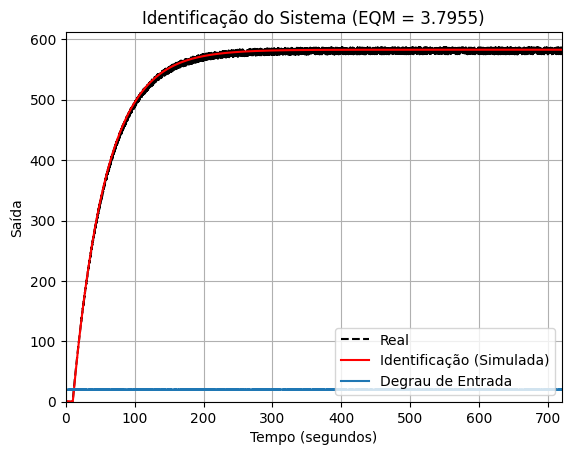

In [125]:
# Plotar a comparação entre a resposta real e a identificada
plt.figure()
plt.plot(tempo, saida_motor, 'k--', label='Real') 
plt.plot(tempo_simulado, saida_simulada, label='Identificação (Simulada)', color='red')
plt.plot(tempo, degrau, label='Degrau de Entrada')
plt.xlabel('Tempo (segundos)')
plt.xlim([0, len(tempo) * 0.1])
plt.ylabel('Saída')
plt.ylim([0, max(max(degrau), max(saida_simulada)) * 1.05])
plt.title(f'Identificação do Sistema (EQM = {erro_quadratico_medio:.4f})')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('images/identificacao.png')
plt.show()

In [126]:
def grafico (tempo_res, sinal_res, tempo, Titulo):
    plt.figure(figsize=(8, 6))
    plt.plot(tempo_res, sinal_res * amplitude_degrau, label= Titulo)
    plt.plot(tempo_res, degrau, label='Degrau de Entrada')
    plt.xlabel('Tempo (segundos)')
    plt.xlim([0, len(tempo) * 0.1])
    plt.ylabel('Saída')
    plt.ylim(-1, 680)
    plt.title(Titulo)
    plt.legend(loc='lower right')
    plt.grid()
    plt.savefig(f'images/{Titulo}.png')
    plt.show()

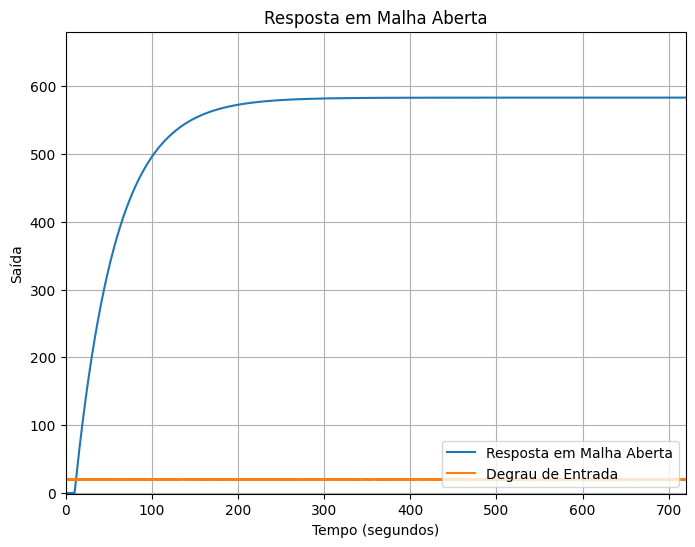

In [127]:
# Questão 4 -> Malha Aberta
malha_aberta = ctl.tf([K], [tau_estimado, 1])
# Adicionando o theta
num_delay, den_delay = ctl.pade(theta_estimado, 20)
malha_aberta_com_theta = ctl.series(ctl.tf(num_delay, den_delay), malha_aberta)
tempo_aberta, saida_aberta = ctl.step_response(malha_aberta_com_theta, tempo)
grafico(tempo_aberta, saida_aberta, tempo, "Resposta em Malha Aberta")

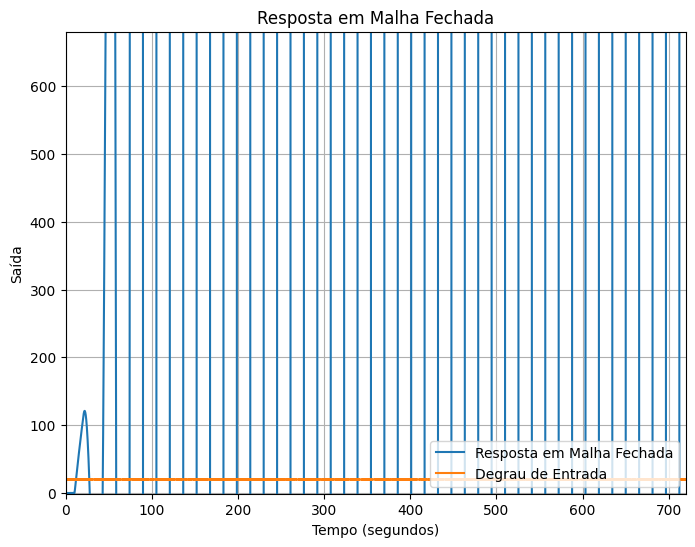

In [128]:
# malha_fechada = ctl.tf([K], [tau_estimado * theta_estimado, tau_estimado, 1])
malha_fechada = ctl.feedback(malha_aberta_com_theta, 1)
# Adicionando o theta
# malha_fechada_com_theta = ctl.series(ctl.tf(num_delay, den_delay), malha_fechada)
tempo_fechada, saida_fechada = ctl.step_response(malha_fechada, tempo)
grafico(tempo_fechada, saida_fechada, tempo, "Resposta em Malha Fechada")

In [129]:
# Controlador CHR (sem sobressinal)

def CHR (kp_chr, ti_chr, td_chr):
    print("\nCONTROLADOR - CHR")
    print(f"Kp = {kp_chr}, Td = {ti_chr}, Ti = {td_chr}.")
    
    pid_chr = [kp_chr * td_chr, kp_chr, kp_chr / ti_chr]
    den_chr = [1, 0]
    controlador_chr = ctl.tf(pid_chr, den_chr)
    
    # Adicionando theta ao controlador CHR
    controlador_chr_com_theta = ctl.series(ctl.tf(num_delay, den_delay), controlador_chr)
    sistema_com_theta = ctl.tf(K, [tau_estimado, 1])
    chr_completo = ctl.series(sistema_com_theta, controlador_chr_com_theta)
    
    sistema_chr_controlado = ctl.feedback(chr_completo, 1)
    tempo_chr, saida_chr = ctl.step_response(sistema_chr_controlado * amplitude_degrau, tempo)
    
    # Sobressinal do CHR
    informacoes_chr = ctl.step_info(sistema_chr_controlado)
    sobressinal_chr = informacoes_chr['Overshoot']
    print(f'OVERSHOOT  com CHR: {sobressinal_chr:.4f}.')
    return (tempo_chr, saida_chr)

In [130]:
ti_chr = tau_estimado
td_chr = theta_estimado / 2
kp_chr = (0.6 * tau_estimado) / (K * theta_estimado)
temp_chr, sinal_resp_chr = CHR(kp_chr, ti_chr, td_chr)


CONTROLADOR - CHR
Kp = 0.0942706915742731, Td = 47.25, Ti = 5.175000000000001.
OVERSHOOT  com CHR: 1.2042.


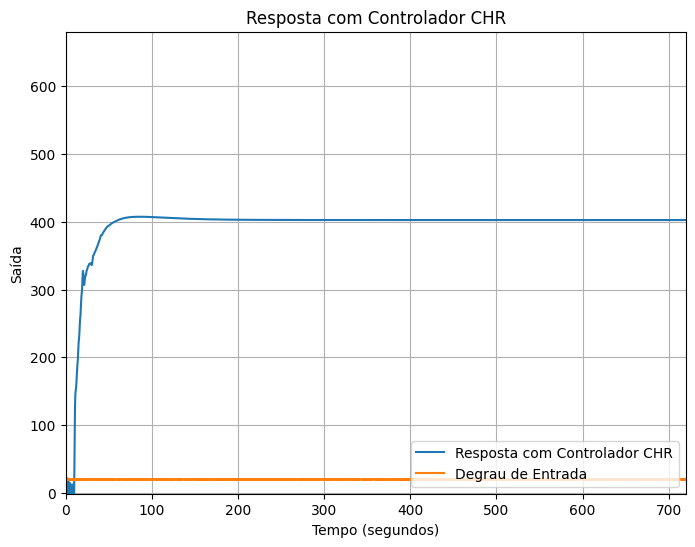

In [131]:
grafico(temp_chr, sinal_resp_chr, tempo, "Resposta com Controlador CHR")

In [132]:
# Controlador ITAE
def ITAE (kp_itae, ti_itae,td_itae):
    print("\nCONTROLADOR - ITAE")
    print(f"Kp = {kp_itae}, Td = {td_itae}, Ti = {ti_itae}.")

    pid_itae = [kp_itae * td_itae, kp_itae, kp_itae / ti_itae]
    den_itae = [1, 0]
    controlador_itae = ctl.tf(pid_itae, den_itae)

    # Adicionando theta
    num_delay, den_delay = ctl.pade(theta, 20)
    pid_itae_delay = ctl.series(ctl.tf(num_delay, den_delay), controlador_itae)

    sys_theta = ctl.tf(K, [tau, 1]) 
    itae = ctl.series(pid_itae_delay, sys_theta)
    sys_ctrl_itae = ctl.feedback(itae, 1)
    temp_ITAE, sinal_ITAE = ctl.step_response(sys_ctrl_itae * amplitude_degrau, tempo)
    
    ITAE_info = ctl.step_info(sys_ctrl_itae) 
    overshoot_itae = ITAE_info['Overshoot']
    print(f'OVERSHOOT por ITAE: {overshoot_itae:.4f}')
    
    return (temp_ITAE, sinal_ITAE)

In [133]:
a, b, c, d, e, f = 0.965, -0.85, 0.796, -0.147, 0.308, 0.929  # Parâmetros do ITAE
kp_itae = (a / K) * ((theta_estimado / tau_estimado) ** b)
ti_itae = tau_estimado / (c + (d * (theta_estimado / tau_estimado)))
td_itae = tau_estimado * e * ((theta_estimado / tau_estimado) ** f)
temp_ITAE, sinal_resp_ITAE = ITAE(kp_itae, ti_itae, td_itae)


CONTROLADOR - ITAE
Kp = 0.12073509734351005, Td = 3.5506905980611756, Ti = 61.86174391201885.
OVERSHOOT por ITAE: 0.0000


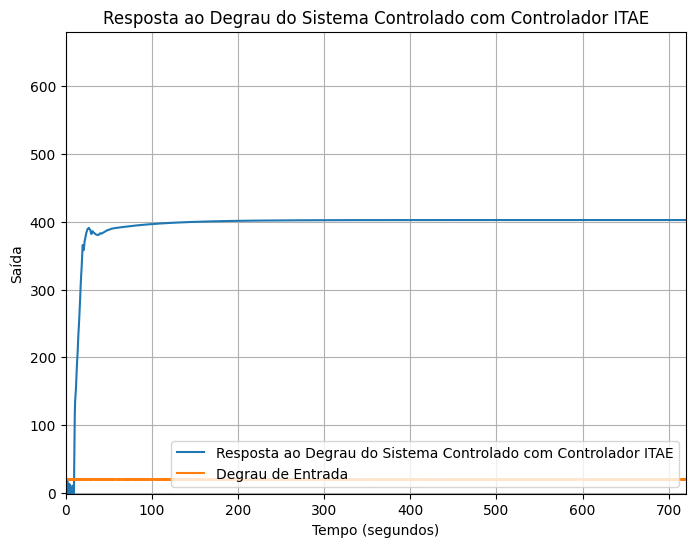

In [134]:
grafico(temp_ITAE, sinal_resp_ITAE, tempo, "Resposta ao Degrau do Sistema Controlado com Controlador ITAE")

In [135]:
# CHR e ITAE AJUSTADO
def ajuste_ITAE_CHR (kp,ti,td):

    # AJUSTE DO CHR:

    tempo_ajuste_chr, sinal_resp_chr = CHR(kp,ti,td)
    grafico(tempo_ajuste_chr, sinal_resp_chr, tempo, "Rsposta do PID por CHR ajustado")
    
    # Ajuste do ITAE
    
    tempo_ajuste_itae, sinal_resp_itae = ITAE(kp,ti,td)
    grafico(tempo_ajuste_itae, sinal_resp_itae, tempo, "Rsposta do PID por ITAE ajustado")

In [136]:
def alterar_pid(tipo):
    print(f"\n Alterando PID por {tipo}")
    print("1 - Alterar Kp")
    print("2 - Alterar Ti")
    print("3 - Alterar Td")
    print("4 - Plotar")
    print("5 - Sair")

In [137]:
def pegar_valor(var):
    while True:
        try:
            valor = float(input(f"Valor {var}: "))
            if valor >= 0:
                return valor
            else:
                print("Valor incorreto, deve ser maior ou igual a zero.")
        except ValueError:
            print("Entrada inválida, insira um número válido.")

In [138]:
def menu_pid(tipo):
    while True:
        alterar_pid(tipo)
        aux = input("Escolha: ")

        if aux == '1':
            Kp = pegar_valor("Kp")
        elif aux == '2':
            Ti = pegar_valor("Ti")
        elif aux == '3':
            Td = pegar_valor("Td")
        elif aux == '4':
            print(f"\nKp = {Kp:.4f}, Ti = {Ti:.4f}, Td = {Td:.4f}.")
            if tipo == "CHR":
                temp_ajust, sinal_ajust = CHR(Kp, Ti, Td)
                grafico(temp_ajust, sinal_ajust, tempo, f"Resposta do PID por CHR ajustado")
        
            else:
                temp_ajust, sinal_ajust = ITAE(Kp, Ti, Td)
                grafico(temp_ajust, sinal_ajust, tempo, f"Resposta do PID por ITAE ajustado")
        elif aux == '5':
            break
        else:
            print("Opção inválida.")

In [139]:
print("\n Alterar PID. \n 1 - PID por CHR; \n 2 - PID por ITAE")
try:
    aux = int(input("Escolha: "))
    if aux == 1:
        menu_pid("CHR")
    elif aux == 2:
        menu_pid("ITAE")
    else:
        print("Opção inválida.")
except ValueError:
    print("Entrada inválida, escolha entre 1 ou 2.")


 Alterar PID. 
 1 - PID por CHR; 
 2 - PID por ITAE
Entrada inválida, escolha entre 1 ou 2.
